# Import Statements

In [426]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# Import Snowflake modules
from snowflake.snowpark import Session
from pyspark.sql.functions import year
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# DATA PREPARATION
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from feature_engine.outliers import Winsorizer

# MODEL BUILDING
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn. ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# MODEL EVALUATION & IMPROVEMENT
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# to export model
import joblib

# Functions

In [427]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [428]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "raw_pos",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [429]:
# retrieve order details usa table from snowflake
order_detail = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_DETAIL")
order_header = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_HEADER")
location_table = session.table("frostbyte_tasty_bytes.raw_pos.LOCATION")

In [430]:
location_table.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                                          |"CITY"      |"REGION"                               |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1001           |222-222@4hf-nch-k2k  |Seasoners Fine Foods                                |Manchester  |Greater Manchester                     |GB                  |England    |
|1002           |222-222@4hf-ndn-4sq  |HM Music Promotions                                 |Manchester  |Greater Manchester                     |GB                  |England    |
|1003           |222-222@4hf-ndp-grk  |G J Hull                                            |Manchester  |

### Filter rows for United States ONLY

In [431]:
# Get a list of LOCATION_IDs where the COUNTRY column's value is 'United States'
## Filter the 'location_table' where the 'COUNTRY' column is 'United States'
filtered_location_table = location_table.filter(location_table['COUNTRY'] == 'United States')

## Select the 'LOCATION_ID' column from the filtered DataFrame
location_id_df = filtered_location_table.select('LOCATION_ID')

## Convert the 'LOCATION_ID' column to a Python list
location_id_list = location_id_df.collect()

## Extract the values from the DataFrame and convert them to a list
location_id_list = [row['LOCATION_ID'] for row in location_id_list]

In [432]:
order_detail.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_DETAIL_ID"  |"ORDER_ID"  |"MENU_ITEM_ID"  |"DISCOUNT_ID"  |"LINE_NUMBER"  |"QUANTITY"  |"UNIT_PRICE"  |"PRICE"  |"ORDER_ITEM_DISCOUNT_AMOUNT"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------
|181474206          |67233172    |51              |NULL           |0              |1           |17.2500       |17.2500  |NULL                          |
|181474208          |67233173    |51              |NULL           |0              |1           |17.2500       |17.2500  |NULL                          |
|181474209          |67233173    |52              |NULL           |1              |1           |17.2500       |17.2500  |NULL                          |
|181474210          |67233173    |53              |NULL           |2              

In [433]:
order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|14271673    |90          |2666.0         |NULL           |NULL           |63645       |15:30:00            |22:30:00          |NULL             |2021-05-

In [434]:
# Merge the two tables using the 'ORDER_ID' column as the common key
merged_df = order_detail.join(order_header, on='ORDER_ID', how='inner')

In [435]:
# Get rows where the LOCATION_ID is for United States
merged_df = merged_df.filter(F.col('LOCATION_ID').isin(location_id_list))

In [436]:
# Filter table for only the required columns
order_df = merged_df.select("MENU_ITEM_ID", "QUANTITY", "ORDER_TS")

In [437]:
order_df.show()

-----------------------------------------------------
|"MENU_ITEM_ID"  |"QUANTITY"  |"ORDER_TS"           |
-----------------------------------------------------
|18              |1           |2022-03-29 08:10:05  |
|17              |2           |2022-03-29 08:10:05  |
|16              |1           |2022-03-29 08:10:05  |
|12              |1           |2022-03-29 08:10:05  |
|10              |1           |2022-03-29 08:10:05  |
|12              |1           |2022-03-29 08:34:54  |
|13              |2           |2022-03-29 08:34:54  |
|15              |2           |2022-03-29 08:34:54  |
|16              |1           |2022-03-29 08:34:54  |
|17              |1           |2022-03-29 08:34:54  |
-----------------------------------------------------



### Feature Engineering: ORDER_TS to get YEAR

In [438]:
# Convert the 'ORDER_TS' column to a java.sql.Timestamp object
order_df = order_df.withColumn('ORDER_TS', F.to_timestamp(order_df['ORDER_TS']))

# Extract the year from the 'ORDER_TS' column
order_df = order_df.withColumn('YEAR', F.year(order_df['ORDER_TS']))

# Drop the 'ORDER_TS' column
order_df = order_df.drop('ORDER_TS')

# Show the modified DataFrame with the 'YEAR' column
order_df.show()

----------------------------------------
|"MENU_ITEM_ID"  |"QUANTITY"  |"YEAR"  |
----------------------------------------
|18              |1           |2022    |
|17              |2           |2022    |
|16              |1           |2022    |
|12              |1           |2022    |
|10              |1           |2022    |
|12              |1           |2022    |
|13              |2           |2022    |
|15              |2           |2022    |
|16              |1           |2022    |
|17              |1           |2022    |
----------------------------------------



In [439]:
# Group by 'YEAR' and 'MENU_ITEM_ID' and calculate the sum of 'QUANTITY'
total_qty_by_item = order_df.group_by(['YEAR', 'MENU_ITEM_ID']) \
                           .agg(F.sum(order_df['QUANTITY']).alias('TOTAL_QTY_SOLD_PER_YEAR')) \
                           .orderBy(['YEAR', 'MENU_ITEM_ID'])

# View the data
total_qty_by_item.show()

-------------------------------------------------------
|"YEAR"  |"MENU_ITEM_ID"  |"TOTAL_QTY_SOLD_PER_YEAR"  |
-------------------------------------------------------
|2019    |10              |5305                       |
|2019    |11              |15597                      |
|2019    |12              |15612                      |
|2019    |13              |15641                      |
|2019    |14              |5211                       |
|2019    |15              |5211                       |
|2019    |16              |5349                       |
|2019    |17              |15560                      |
|2019    |18              |15759                      |
|2019    |19              |15658                      |
-------------------------------------------------------



In [440]:
order_df_grp_by = total_qty_by_item.to_pandas()

### Account for missing Nov & Dec 2022 quantity sold for all menu items

In [441]:
# result before adding the assumed missing Dec 2022 qty sold for all items
order_df_grp_by[order_df_grp_by["YEAR"]==2022].head()

,YEAR,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_YEAR
228,2022,10,149318
229,2022,11,443405
230,2022,12,441775
231,2022,13,441694
232,2022,14,149397


In [442]:
order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"] = np.where(
    order_df_grp_by["YEAR"] == 2022,
    np.ceil((order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"] / 10) * 12),
    order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"]
)

In [443]:
order_df_grp_by[order_df_grp_by["YEAR"]==2022].head()

,YEAR,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_YEAR
228,2022,10,179182.0
229,2022,11,532086.0
230,2022,12,530130.0
231,2022,13,530033.0
232,2022,14,179277.0


In [444]:
# order_df_grp_by.to_csv('C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/datasets/total_qty_by_item.csv', index=False)

# Menu Table 

In [445]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU")

In [446]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = menu_data_from_snowflake.to_pandas()

In [447]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, order_df_grp_by, on='MENU_ITEM_ID')

In [448]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,YEAR,TOTAL_QTY_SOLD_PER_YEAR
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,5305.0
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2020,26284.0
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2021,159322.0
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,179182.0
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,15597.0


### Feature Engineering: MENU_ITEM_HEALTH_METRICS_OBJ 

In [449]:
# Convert the string JSON data to a nested dictionary
menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'] = menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'].apply(ast.literal_eval)

# Use json_normalize to flatten the nested JSON data
menu_item_metrics = pd.json_normalize(menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'], record_path='menu_item_health_metrics')

# Rename the columns
menu_item_metrics = menu_item_metrics.rename(columns={
    'is_dairy_free_flag': 'DAIRY_FREE',
    'is_gluten_free_flag': 'GLUTEN_FREE',
    'is_healthy_flag': 'HEALTHY',
    'is_nut_free_flag': 'NUT_FREE'
})

# Replace 'Y' with 'Yes' and 'N' with 'No' in the DataFrame
menu_item_metrics = menu_item_metrics.replace({'Y': 1, 'N': 0})

# Concatenate the flattened DataFrame with the original DataFrame
menu_df = pd.concat([menu_df, menu_item_metrics], axis=1)

# Drop the original 'MENU_ITEM_HEALTH_METRICS_OBJ' and 'ingredients' column 
menu_df = menu_df.drop(columns=['MENU_ITEM_HEALTH_METRICS_OBJ', 'ingredients'])

In [450]:
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,5305.0,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,26284.0,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,159322.0,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,179182.0,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,15597.0,1,1,0,1


# Final Table

In [451]:
final_df = menu_df

In [452]:
final_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,5305.0,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,26284.0,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,159322.0,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,179182.0,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,15597.0,1,1,0,1


In [453]:
# convert target to int type
final_df['TOTAL_QTY_SOLD_PER_YEAR'] = final_df['TOTAL_QTY_SOLD_PER_YEAR'].astype(int)

In [454]:
final_df = final_df.drop(["COST_OF_GOODS_USD", "MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_NAME", "TRUCK_BRAND_NAME"], axis=1)
final_df.head()

,MENU_TYPE,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,10,Beverage,Cold Option,3.5,2019,5305,1,1,0,1
1,Ice Cream,10,Beverage,Cold Option,3.5,2020,26284,1,1,0,1
2,Ice Cream,10,Beverage,Cold Option,3.5,2021,159322,1,1,0,1
3,Ice Cream,10,Beverage,Cold Option,3.5,2022,179182,1,1,0,1
4,Ice Cream,11,Dessert,Cold Option,6.0,2019,15597,1,1,0,1


### Ordinal Encoding for ITEM_SUBCATEGORY

In [455]:
# Define the mapping dictionary
temperature_mapping = {'Cold Option': 0, 'Warm Option': 1, 'Hot Option': 2}

# Apply the mapping to the 'ITEM_SUBCATEGORY' column in final_df
final_df['ITEM_SUBCATEGORY'] = final_df['ITEM_SUBCATEGORY'].map(temperature_mapping)

final_df.head()

,MENU_TYPE,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,10,Beverage,0,3.5,2019,5305,1,1,0,1
1,Ice Cream,10,Beverage,0,3.5,2020,26284,1,1,0,1
2,Ice Cream,10,Beverage,0,3.5,2021,159322,1,1,0,1
3,Ice Cream,10,Beverage,0,3.5,2022,179182,1,1,0,1
4,Ice Cream,11,Dessert,0,6.0,2019,15597,1,1,0,1


# Check for Missing Values

In [456]:
final_df.isnull().sum()

MENU_TYPE                  0
MENU_ITEM_ID               0
ITEM_CATEGORY              0
ITEM_SUBCATEGORY           0
SALE_PRICE_USD             0
YEAR                       0
TOTAL_QTY_SOLD_PER_YEAR    0
DAIRY_FREE                 0
GLUTEN_FREE                0
HEALTHY                    0
NUT_FREE                   0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

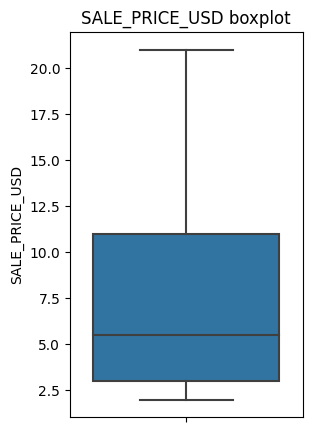

In [457]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['SALE_PRICE_USD'])
plt.title('SALE_PRICE_USD boxplot')
plt.show()

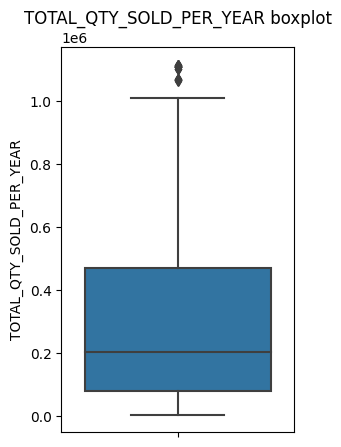

In [458]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD_PER_YEAR'])
plt.title('TOTAL_QTY_SOLD_PER_YEAR boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# View Target Column Range

In [459]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].min()
max_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 5211 - 1115334


# Train Test Split

In [460]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD_PER_YEAR', axis=1), final_df['TOTAL_QTY_SOLD_PER_YEAR'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((229, 10), (99, 10))

# Categorical Variable Encoding 

In [461]:
# Specify the columns to encode
columns_to_encode = ["MENU_TYPE", "ITEM_CATEGORY"]

ohe_enc = OneHotEncoder(variables=columns_to_encode, drop_last=True)

In [462]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode
ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True, variables=['MENU_TYPE', 'ITEM_CATEGORY'])

In [463]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [464]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [465]:
# # Save the model to a file
# joblib.dump(scaler, "C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/models/product_qty_year_min_max_scaler.joblib")

## Standard Scaler

In [466]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [467]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [468]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Models

## Linear Regression

In [469]:
# create the linear regression model
# fit the model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [470]:
# Calculated the fitted values for training set
y_fitted = lm.predict(X_train)

# Task 5a: calculated the predicated value for testing data
y_pred = lm.predict(X_test)

In [471]:
model_performance(lm)

the training root mean squared error is:  364704771.8544002
the testing root mean squared error is:  364793234.4038548

the training mean squared error is:  1.3300957061337013e+17
the testing mean squared error is:  1.3307410386682576e+17

training accuracy is:  -1143818.783801821
testing accuracy is:  -1202068.9759948405


## Decision Tree

In [472]:
# Create Decision Tree Regressor with random state equal to 2
# fit the model to the training data
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [473]:
model_performance(tree_reg)

the training root mean squared error is:  452885.39791219245
the testing root mean squared error is:  410036.40244012943

the training mean squared error is:  205105183642.0849
the testing mean squared error is:  168129851326.0438

training accuracy is:  -0.7638081660459104
testing accuracy is:  -0.5187315974697038


## MLP Regressor

In [474]:
# Create the ann model
mlp = MLPRegressor(activation ='relu', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)
# Fit the model to the training set
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10,), max_iter=2000, random_state=2,
             solver='sgd')

In [475]:
model_performance(mlp)

the training root mean squared error is:  6787170574540.619
the testing root mean squared error is:  6787170516150.827

the training mean squared error is:  4.606568440791004e+25
the testing mean squared error is:  4.606568361530708e+25

training accuracy is:  -396143231928018.56
testing accuracy is:  -416115334152870.3


## ADA Boost Regressor

In [476]:
# Build Ada Boost Model 
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators = 20, learning_rate =0.1)
# fit the model to the training data
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, n_estimators=20)

In [477]:
model_performance(ada_reg)

the training root mean squared error is:  447423.04373784026
the testing root mean squared error is:  408720.5647773033

the training mean squared error is:  200187380067.63333
the testing mean squared error is:  167052500071.87778

training accuracy is:  -0.7215173670051411
testing accuracy is:  -0.5089997897129566


## SVR

In [478]:
svr = SVR(C=0.8, kernel ='rbf')
svr.fit(X_train, y_train)

SVR(C=0.8)

In [479]:
model_performance(svr)

the training root mean squared error is:  363479.5713944172
the testing root mean squared error is:  339487.34225504333

the training mean squared error is:  132117398821.06921
the testing mean squared error is:  115251655551.39291

training accuracy is:  -0.13614752576897593
testing accuracy is:  -0.04107824735512278


## XGBoost Regressor

In [480]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  78288.44824375055
the testing root mean squared error is:  86440.11947706187

the training mean squared error is:  6129081128.414408
the testing mean squared error is:  7471894255.208733

training accuracy is:  0.9472927833773332
testing accuracy is:  0.9325057281093304


In [481]:
# Get the feature importances
feature_importance = xgb.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                     Feature  Importance
2             SALE_PRICE_USD    0.711669
3                       YEAR    0.110904
0               MENU_ITEM_ID    0.037924
22    ITEM_CATEGORY_Beverage    0.031477
16           MENU_TYPE_Ramen    0.027188
10         MENU_TYPE_Chinese    0.019973
15      MENU_TYPE_Vegetarian    0.015197
13           MENU_TYPE_Gyros    0.012747
4                 DAIRY_FREE    0.008340
21    MENU_TYPE_Mac & Cheese    0.006357
20  MENU_TYPE_Grilled Cheese    0.005510
17          MENU_TYPE_Crepes    0.003572
8        MENU_TYPE_Ethiopian    0.003532
1           ITEM_SUBCATEGORY    0.002714
14           MENU_TYPE_Tacos    0.001153
24        ITEM_CATEGORY_Main    0.000940
12        MENU_TYPE_Hot Dogs    0.000563
11             MENU_TYPE_BBQ    0.000242
9        MENU_TYPE_Ice Cream    0.000000
18         MENU_TYPE_Poutine    0.000000
19      MENU_TYPE_Sandwiches    0.000000
7                   NUT_FREE    0.000000
6                    HEALTHY    0.000000
5               

In [482]:
# Get the column names with importance score not equal to 0
selected_features = feature_importance_df[feature_importance_df['Importance'] != 0]['Feature'].tolist()

# Update the X_train_scaled and X_test_scaled with the selected features
X_train_scaled = X_train_scaled[selected_features]
X_test_scaled = X_test_scaled[selected_features]

In [483]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  78288.44824375055
the testing root mean squared error is:  86138.99467814028

the training mean squared error is:  6129081128.414408
the testing mean squared error is:  7419926404.160679

training accuracy is:  0.9472927833773332
testing accuracy is:  0.9329751582362042


In [484]:
# Build XGBoost Model
xgb_updated = XGBRegressor(n_estimators=31, learning_rate=0.1, max_depth = 8, use_label_encoder=False, eval_metric='logloss')

# Fit the model to the updated training data
xgb_updated.fit(X_train_scaled, y_train)

# Evaluate the performance of the updated model
model_performance(xgb_updated)

the training root mean squared error is:  29394.099261555468
the testing root mean squared error is:  49728.38314437181

the training mean squared error is:  864013071.3981757
the testing mean squared error is:  2472912090.1534424

training accuracy is:  0.9925698937304195
testing accuracy is:  0.977661969605875


In [485]:
# # Save the model to a file
# joblib.dump(xgb_updated, "C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/models/product_qty_year_xgb_model.joblib")

# Model Improvement (GridSearch CV)

In [486]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50],
              'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [1,2,3,4,5]}

xgb_grid = GridSearchCV(xgb_updated, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

best_params = xgb_grid.best_params_
print("Best parameters found: ", best_params)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best score found:  0.9475490207971239


# Improved Model 

In [487]:
# Build XGBoost Model
xgb_improved = XGBRegressor(**best_params)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  12549.14652180854
the testing root mean squared error is:  57437.93529306729

the training mean squared error is:  157481078.42581937
the testing mean squared error is:  3299116410.7305846

training accuracy is:  0.9986457367522711
testing accuracy is:  0.9701987939845919


# Cross Validation

In [488]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

In [489]:
# Evaluate the Model using K-folds Cross validation
results  = cross_validate(xgb, X_combined, y_combined, scoring='neg_mean_squared_error', cv=5, return_train_score = True)

# Convert the negative mean squared errors to positive RMSE values
train_rmse_scores = np.sqrt(-results['train_score'])
test_rmse_scores = np.sqrt(-results['test_score'])

# Print the RMSE scores for each fold
print('Train RMSE Scores:', train_rmse_scores)
print('Test RMSE Scores:', test_rmse_scores)

Train RMSE Scores: [75339.63801992 74142.43332007 75605.71434306 76416.37950753
 76063.86825282]
Test RMSE Scores: [ 80185.80429824 101407.47048578 115702.64964143 100176.20125787
  98741.64001118]


In [490]:
# Evaluate the Model using K-folds Cross validation
results  = cross_validate(xgb_updated, X_combined, y_combined, scoring='neg_mean_squared_error', cv=5, return_train_score = True)

# Convert the negative mean squared errors to positive RMSE values
train_rmse_scores = np.sqrt(-results['train_score'])
test_rmse_scores = np.sqrt(-results['test_score'])

# Print the RMSE scores for each fold
print('Train RMSE Scores:', train_rmse_scores)
print('Test RMSE Scores:', test_rmse_scores)

Train RMSE Scores: [27912.69165515 27654.15903177 28239.80840237 28957.84596958
 28303.77768502]
Test RMSE Scores: [33921.09266666 46278.53327918 84371.73078771 75455.60108624
 63787.60610611]


In [491]:
# Evaluate the Model using K-folds Cross validation
results  = cross_validate(xgb_improved, X_combined, y_combined, scoring='neg_mean_squared_error', cv=5, return_train_score = True)

# Convert the negative mean squared errors to positive RMSE values
train_rmse_scores = np.sqrt(-results['train_score'])
test_rmse_scores = np.sqrt(-results['test_score'])

# Print the RMSE scores for each fold
print('Train RMSE Scores:', train_rmse_scores)
print('Test RMSE Scores:', test_rmse_scores)

Train RMSE Scores: [11370.93458898 11336.6756676  12057.07200429 13836.64646702
 11041.64176627]
Test RMSE Scores: [33636.23190048 39783.03766672 67558.86505968 39713.50912997
 45192.53512137]


# Feature Importance

In [492]:
# Get the feature importances
feature_importance = xgb_updated.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                     Feature  Importance
0             SALE_PRICE_USD    0.554223
1                       YEAR    0.201168
3     ITEM_CATEGORY_Beverage    0.059672
2               MENU_ITEM_ID    0.052204
4            MENU_TYPE_Ramen    0.039993
5          MENU_TYPE_Chinese    0.038876
6       MENU_TYPE_Vegetarian    0.025376
13          ITEM_SUBCATEGORY    0.008261
7            MENU_TYPE_Gyros    0.006490
10  MENU_TYPE_Grilled Cheese    0.003240
12       MENU_TYPE_Ethiopian    0.002265
16        MENU_TYPE_Hot Dogs    0.002090
15        ITEM_CATEGORY_Main    0.001631
8                 DAIRY_FREE    0.001399
11          MENU_TYPE_Crepes    0.001351
9     MENU_TYPE_Mac & Cheese    0.000938
14           MENU_TYPE_Tacos    0.000555
17             MENU_TYPE_BBQ    0.000268


# Insights for Streamlit Data Pre-Processing

In [493]:
X_train_scaled.head()

,SALE_PRICE_USD,YEAR,MENU_ITEM_ID,ITEM_CATEGORY_Beverage,MENU_TYPE_Ramen,MENU_TYPE_Chinese,MENU_TYPE_Vegetarian,MENU_TYPE_Gyros,DAIRY_FREE,MENU_TYPE_Mac & Cheese,MENU_TYPE_Grilled Cheese,MENU_TYPE_Crepes,MENU_TYPE_Ethiopian,ITEM_SUBCATEGORY,MENU_TYPE_Tacos,ITEM_CATEGORY_Main,MENU_TYPE_Hot Dogs,MENU_TYPE_BBQ
0,0.052632,1.000000,0.582192,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.105263,0.333333,0.047945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.578947,1.000000,0.828767,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.052632,0.000000,0.034247,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.789474,0.666667,0.082192,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [494]:
X_train_scaled.columns

Index(['SALE_PRICE_USD', 'YEAR', 'MENU_ITEM_ID', 'ITEM_CATEGORY_Beverage',
       'MENU_TYPE_Ramen', 'MENU_TYPE_Chinese', 'MENU_TYPE_Vegetarian',
       'MENU_TYPE_Gyros', 'DAIRY_FREE', 'MENU_TYPE_Mac & Cheese',
       'MENU_TYPE_Grilled Cheese', 'MENU_TYPE_Crepes', 'MENU_TYPE_Ethiopian',
       'ITEM_SUBCATEGORY', 'MENU_TYPE_Tacos', 'ITEM_CATEGORY_Main',
       'MENU_TYPE_Hot Dogs', 'MENU_TYPE_BBQ'],
      dtype='object')